In [1]:
import torch
import torchvision
import argparse
import yaml
import os
from torchvision.utils import make_grid
from PIL import Image
from tqdm import tqdm
from models.unet_cond_base import Unet
from models.vqvae import VQVAE
from scheduler.linear_noise_scheduler import LinearNoiseScheduler
from scheduler.linear_noise_scheduler_ddim import LinearNoiseSchedulerDDIM
from utils.config_utils import *
from collections import OrderedDict
from datetime import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def sample(model, cond, scheduler, train_config, diffusion_model_config,
           autoencoder_model_config, diffusion_config, dataset_config, vae, use_ddim=False, start_step=0, num_steps=1000, noise_input=None, dir=''):
    r"""
    Sample stepwise by going backward one timestep at a time.
    We save the x0 predictions
    """

    # seed random for reproducibility
    #torch.manual_seed(9)

    im_size = dataset_config['im_size'] // 2 ** sum(autoencoder_model_config['down_sample'])
    
    ########### Sample random noise latent ##########
    if noise_input is not None:
        xt = noise_input.to(device)
    else:
        xt = torch.randn((train_config['num_samples'],
                        autoencoder_model_config['z_channels'],
                        im_size,
                        im_size)).to(device)
    ###############################################
    
    ############# Validate the config #################
    condition_config = get_config_value(diffusion_model_config, key='condition_config', default_value=None)
    assert condition_config is not None, ("This sampling script is for class conditional "
                                          "but no conditioning config found")
    condition_types = get_config_value(condition_config, 'condition_types', [])
    assert 'attribute' in condition_types, ("This sampling script is for attribute conditional "
                                          "but no class condition found in config")
    #validate_class_config(condition_config)
    ###############################################
    
    ############ Create Conditional input ###############
    num_classes = condition_config['attribute_condition_config']['attribute_condition_num']
    #sample_classes = torch.randint(0, num_classes, (train_config['num_samples'], ))
    #print('Generating images for {}'.format(list(sample_classes.numpy())))
    cond_input = {
        # 'class': torch.nn.functional.one_hot(sample_classes, num_classes).to(device)
        #  ['Male', 'Young', 'Bald', 'Bangs', 'Receding_Hairline', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair', 'Straight_Hair', 'Wavy_Hair', 'No_Beard', 'Goatee', 'Mustache', 'Sideburns', 'Narrow_Eyes', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose']
        'attribute': cond

    }
    # Unconditional input for classifier free guidance
    uncond_input = {
        'attribute': cond_input['attribute'] * 0
    }
    ###############################################
    
    # By default classifier free guidance is disabled
    # Change value in config or change default value here to enable it
    cf_guidance_scale = get_config_value(train_config, 'cf_guidance_scale', 1.0)
    
    current_time = datetime.now().strftime("%Y%m%d-%H%M%S")

    if not use_ddim:
        num_steps = diffusion_config['num_timesteps']
    
    ################# Sampling Loop ########################
    for i in tqdm(reversed(range(num_steps - start_step)), total=num_steps):
        timestep = ((i-1) * (1000 // num_steps)) + 1
        #print(timestep)
        
        # Get prediction of noise
        t = (torch.ones((xt.shape[0],))*timestep).long().to(device)
        noise_pred_cond = model(xt, t, cond_input)
        
        if cf_guidance_scale > 1:
            noise_pred_uncond = model(xt, t, uncond_input)
            noise_pred = noise_pred_uncond + cf_guidance_scale*(noise_pred_cond - noise_pred_uncond)
        else:
            noise_pred = noise_pred_cond
        
        # If DDIM is enabled, we need to also compute t_prev for the DDIM reverse process
        if use_ddim:
            t_prev = (torch.ones((xt.shape[0],)).to(device) * max(t - (1000 // num_steps), 1)).long().to(device)
            xt, x0_pred = scheduler.sample_prev_timestep(xt, noise_pred, t, t_prev)  # Use DDIM sampling
        else:
            xt, x0_pred = scheduler.sample_prev_timestep(xt, noise_pred, torch.as_tensor(i).to(device))  # Use DDPM sampling
       
        if i == 0:
            # Decode ONLY the final image to save time
            ims = vae.decode(xt)
        else:
            ims = x0_pred
        
        ims = torch.clamp(ims, -1., 1.).detach().cpu()
        ims = (ims + 1) / 2
        grid = make_grid(ims, nrow=1)
        img = torchvision.transforms.ToPILImage()(grid)

        if not os.path.exists(os.path.join(train_config['task_name'], 'cond_attr_samples', dir, current_time)):
            os.makedirs(os.path.join(train_config['task_name'], 'cond_attr_samples', dir, current_time), exist_ok=True)
        img.save(os.path.join(train_config['task_name'], 'cond_attr_samples', dir, current_time, 'x0_{}.png'.format(i)))
        img.close()
    ##############################################################

    return ims, cond_input

def ddim_inversion(scheduler, vae, xt, diffusion_config, condition_input, model, train_config, num_inference_steps=None, dir='', save_img=True):
    r"""
    Reverse the process by diffusing the image forward in time.
    :param scheduler: the noise scheduler used (e.g., LinearNoiseSchedulerDDIM)
    :param vae: the variational autoencoder (VAE) to encode and decode images
    :param xt: image tensor that will be diffused forward
    :param diffusion_config: configuration for the diffusion process
    :param condition_input: the conditioning input for the image
    :param model: the diffusion model (e.g., Unet)
    :param train_config: the training configuration
    """

    xt = xt.to(device)  # Ensure image is on the correct device
    xt = (xt * 2) - 1  # Rescale from [0, 1] to [-1, 1] to match the model's input range

    # First, encode the image into latent space using the VAE
    z, _ = vae.encode(xt)

    all_timesteps = diffusion_config['num_timesteps']

    # If the number of inference steps is not provided, use all timesteps
    if num_inference_steps is None:
        num_timesteps = all_timesteps

    current_time = datetime.now().strftime("%Y%m%d-%H%M%S")

    
    intermediate_latents = []
    # Move forward in time by applying noise progressively
    for i in tqdm(range(1, num_inference_steps), total=num_inference_steps):
        t = (torch.ones((z.shape[0],)) * (i * (all_timesteps // num_inference_steps) + 1)).long().to(z.device)

        if i >= num_inference_steps - 1: continue

        # Predict noise based on current step and conditions
        noise_pred = model(z, t, condition_input)
        
        next_timestep = t
        current_timestep = max(0, t - (all_timesteps // num_inference_steps))

        # Use the noise prediction to forward-sample to the next timestep using DDIM forward equation
        # Reverse the reverse process from sample_prev_timestep
        alpha_t = scheduler.alpha_cum_prod.to(z.device)[current_timestep]
        alpha_t_next = scheduler.alpha_cum_prod.to(z.device)[next_timestep]
        
        '''
        z_next = (
            torch.sqrt(alpha_t_next) * z +
            torch.sqrt(1 - alpha_t_next) * noise_pred
        )
        '''

        z_next = (z - torch.sqrt(1 - alpha_t) * noise_pred) * (torch.sqrt(alpha_t_next) / torch.sqrt(alpha_t)) + torch.sqrt(1 - alpha_t_next) * noise_pred
        
        # Optionally, if stochasticity is involved (if ddim_eta > 0), add noise at each step
        if scheduler.ddim_eta > 0:
            variance = (1 - alpha_t_next) / (1 - alpha_t) * scheduler.betas.to(z.device)[t]
            sigma = scheduler.ddim_eta * torch.sqrt(variance)
            z_next = z_next + sigma * torch.randn_like(z_next)
        
        z = z_next  # Move to the next time step

        intermediate_latents.append(z)

        if save_img:
            ims_clamped = torch.clamp(z, -1., 1.).detach().cpu()
            ims_clamped = (ims_clamped + 1) / 2  # Rescale to [0, 1]
            
            # Convert to image and save
            grid = make_grid(ims_clamped, nrow=1)
            img = torchvision.transforms.ToPILImage()(grid)
            
            # Save images at each step for visualization
            save_dir = os.path.join(train_config['task_name'], 'cond_attr_samples', dir, current_time)
            if not os.path.exists(save_dir):
                os.makedirs(save_dir, exist_ok=True)

            
                # Save the image corresponding to the current timestep
                img.save(os.path.join(save_dir, 'x0_{}.png'.format(i)))
            img.close()

    # convert to torch tensor
    intermediate_latents = torch.stack(intermediate_latents, dim=0)

    # Return the final noisy latent z and the predicted noise used for the inversion
    return intermediate_latents


In [2]:
# Read the config file #
with open('celebhq-1024-64-16k-komondor/celeba_komondor_16k.yaml', 'r') as file:
#with open('celebhq-512-64/celeba_komondor_512.yaml', 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)
print(config)
########################

diffusion_config = config['diffusion_params']
dataset_config = config['dataset_params']
diffusion_model_config = config['ldm_params']
autoencoder_model_config = config['autoencoder_params']
train_config = config['train_params']
sample_config = config['sample_params']

########## Create the noise scheduler #############

if sample_config['use_ddim']:
    print('Using DDIM')
    scheduler = LinearNoiseSchedulerDDIM(num_timesteps=diffusion_config['num_timesteps'],
                                            beta_start=diffusion_config['beta_start'],
                                            beta_end=diffusion_config['beta_end'])
else:
    scheduler = LinearNoiseScheduler(num_timesteps=diffusion_config['num_timesteps'],
                                    beta_start=diffusion_config['beta_start'],
                                    beta_end=diffusion_config['beta_end'])
###############################################

########## Load Unet #############
model = Unet(im_channels=autoencoder_model_config['z_channels'],
                model_config=diffusion_model_config).to(device)
model.eval()
if os.path.exists(os.path.join(train_config['task_name'],
                                train_config['ldm_ckpt_name'])):
    

    ddp_state_dict = torch.load(os.path.join(train_config['task_name'],
                                                    train_config['ldm_ckpt_name']),
                                        map_location=device)
    new_state_dict = OrderedDict()
    for k, v in ddp_state_dict.items():
        if k.startswith('module.'):
            name = k[7:] # remove `module.`
        new_state_dict[name] = v
    
    ddp_state_dict = new_state_dict
    print('Loaded unet checkpoint')
    model.load_state_dict(ddp_state_dict)
else:
    raise Exception('Model checkpoint {} not found'.format(os.path.join(train_config['task_name'],
                                                                        train_config['ldm_ckpt_name'])))
#####################################

# Create output directories
if not os.path.exists(train_config['task_name']):
    os.mkdir(train_config['task_name'])

########## Load VQVAE #############
vae = VQVAE(im_channels=dataset_config['im_channels'],
            model_config=autoencoder_model_config).to(device)
vae.eval()

# Load vae if found
if os.path.exists(os.path.join(train_config['task_name'],
                                train_config['vqvae_autoencoder_ckpt_name'])):
    print('Loaded vae checkpoint')

    vae_state_dict = torch.load(os.path.join(train_config['task_name'],
                                                train_config['vqvae_autoencoder_ckpt_name']),
                                    map_location=device)
    
    
    new_state_dict = OrderedDict()

    for k, v in vae_state_dict.items():
        if k.startswith('module.'):
            name = k[7:]
        new_state_dict[name] = v   

    #new_state_dict = vae_state_dict     
    
    vae.load_state_dict(new_state_dict, strict=True)
else:
    raise Exception('VAE checkpoint {} not found'.format(os.path.join(train_config['task_name'],
                                                train_config['vqvae_autoencoder_ckpt_name'])))
#####################################



{'task_name': 'celebhq-1024-64-16k-komondor', 'continue': False, 'last_step': 476, 'last_epoch': 18, 'dataset_params': {'im_path': 'data/CelebAMask-HQ', 'im_channels': 3, 'im_size': 1024, 'name': 'celebhq'}, 'diffusion_params': {'num_timesteps': 1000, 'beta_start': 0.0015, 'beta_end': 0.0195}, 'ldm_params': {'down_channels': [256, 384, 512, 768], 'mid_channels': [768, 512], 'down_sample': [True, True, True], 'attn_down': [True, True, True], 'time_emb_dim': 512, 'norm_channels': 32, 'num_heads': 16, 'conv_out_channels': 128, 'num_down_layers': 2, 'num_mid_layers': 2, 'num_up_layers': 2, 'condition_config': {'condition_types': ['attribute'], 'attribute_condition_config': {'attribute_condition_num': 19, 'attribute_condition_selected_attrs': ['Male', 'Young', 'Bald', 'Bangs', 'Receding_Hairline', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair', 'Straight_Hair', 'Wavy_Hair', 'No_Beard', 'Goatee', 'Mustache', 'Sideburns', 'Narrow_Eyes', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose']}}}, 'aut

In [3]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")

In [4]:
im_size = dataset_config['im_size'] // 2 ** sum(autoencoder_model_config['down_sample'])

torch.manual_seed(9)

noise_input = torch.randn((train_config['num_samples'],
                        autoencoder_model_config['z_channels'],
                        im_size,
                        im_size)).to(device)

In [18]:
#  ['Male', 'Young', 'Bald', 'Bangs', 'Receding_Hairline', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair', 'Straight_Hair', 'Wavy_Hair', 'No_Beard', 'Goatee', 'Mustache', 'Sideburns', 'Narrow_Eyes', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose']
cond = torch.tensor([[1, # Male
                      0, # Young
                      0, # Bald
                      1, # Bangs
                      0, # Receding_Hairline
                      0, # Black_Hair
                      1, # Blond_Hair
                      0, # Brown_Hair
                      0, # Gray_Hair
                      0, # Straight_Hair
                      1, # Wavy_Hair
                      1, # No_Beard
                      0, # Goatee
                      0, # Mustache
                      0, # Sideburns
                      0, # Narrow_Eyes
                      0, # Oval_Face
                      0, # Pale_Skin
                      0  # Pointy_Nose
                      ]]).to(device)

In [19]:
scheduler = LinearNoiseSchedulerDDIM(num_timesteps=diffusion_config['num_timesteps'],
                                            beta_start=diffusion_config['beta_start'],
                                            beta_end=diffusion_config['beta_end'])

In [20]:
with torch.no_grad():
    for i in range(1):
        ims, cond = sample(model, cond, scheduler, train_config, diffusion_model_config,
                    autoencoder_model_config, diffusion_config, dataset_config, vae, use_ddim=True, dir=current_time, noise_input=noise_input, num_steps=1000)

    

100%|██████████| 1000/1000 [02:10<00:00,  7.65it/s]


In [21]:
with torch.no_grad():
    intermediate_latents = ddim_inversion(scheduler, vae, ims, diffusion_config, cond, model, train_config, 1000, dir=current_time)
    
    print(intermediate_latents.shape)

100%|█████████▉| 999/1000 [02:10<00:00,  7.67it/s]

torch.Size([998, 1, 3, 64, 64])


In [22]:
start_latent = intermediate_latents[-1]

In [23]:
#  ['Male', 'Young', 'Bald', 'Bangs', 'Receding_Hairline', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair', 'Straight_Hair', 'Wavy_Hair', 'No_Beard', 'Goatee', 'Mustache', 'Sideburns', 'Narrow_Eyes', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose']
cond = torch.tensor([[1, # Male
                      0, # Young
                      0, # Bald
                      1, # Bangs
                      0, # Receding_Hairline
                      0, # Black_Hair
                      1, # Blond_Hair
                      0, # Brown_Hair
                      0, # Gray_Hair
                      0, # Straight_Hair
                      1, # Wavy_Hair
                      1, # No_Beard
                      0, # Goatee
                      0, # Mustache
                      0, # Sideburns
                      0, # Narrow_Eyes
                      0, # Oval_Face
                      0, # Pale_Skin
                      0  # Pointy_Nose
                      ]]).to(device)

In [24]:
with torch.no_grad():
    sample(model, cond, scheduler, train_config, diffusion_model_config, autoencoder_model_config, 
            diffusion_config, dataset_config, vae, use_ddim=True, start_step=0, noise_input=start_latent, dir=current_time, num_steps=1000)

100%|██████████| 1000/1000 [02:11<00:00,  7.61it/s]


# Existing val image with glasses, ddim and resmpling

In [10]:
from dataset.celeb_dataset import CelebDataset

In [15]:
diffusion_model_config = config['ldm_params']
print(diffusion_model_config)

{'down_channels': [256, 384, 512, 768], 'mid_channels': [768, 512], 'down_sample': [True, True, True], 'attn_down': [True, True, True], 'time_emb_dim': 512, 'norm_channels': 32, 'num_heads': 16, 'conv_out_channels': 128, 'num_down_layers': 2, 'num_mid_layers': 2, 'num_up_layers': 2, 'condition_config': {'condition_types': ['attribute'], 'attribute_condition_config': {'attribute_condition_num': 26, 'attribute_condition_selected_attrs': ['Male', 'Young', 'Bald', 'Bangs', 'Receding_Hairline', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair', 'Straight_Hair', 'Wavy_Hair', 'No_Beard', 'Goatee', 'Mustache', 'Sideburns', 'Narrow_Eyes', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Eyeglasses', 'Heavy_Makeup', 'Lipstick', 'Eyeglasses', 'Heavy_Makeup', 'Lipstick', 'Wearing_Lipstick']}}}


In [16]:
print(diffusion_model_config['condition_config']['attribute_condition_config']['attribute_condition_selected_attrs'] )

['Male', 'Young', 'Bald', 'Bangs', 'Receding_Hairline', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair', 'Straight_Hair', 'Wavy_Hair', 'No_Beard', 'Goatee', 'Mustache', 'Sideburns', 'Narrow_Eyes', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Eyeglasses', 'Heavy_Makeup', 'Lipstick', 'Eyeglasses', 'Heavy_Makeup', 'Lipstick', 'Wearing_Lipstick']


In [17]:
temp_conf = diffusion_model_config.copy()

In [18]:
# add Eyeglasses to the condition
temp_conf['condition_config']['attribute_condition_config']['attribute_condition_selected_attrs'].extend(['Eyeglasses', 'Heavy_Makeup', 'Wearing_Lipstick'])
temp_conf['condition_config']['attribute_condition_config']['attribute_condition_num'] = len(temp_conf['condition_config']['attribute_condition_config']['attribute_condition_selected_attrs'])

In [120]:
im_dataset = CelebDataset(split='val',
                                im_path=dataset_config['im_path'],
                                im_size=dataset_config['im_size'],
                                im_channels=dataset_config['im_channels'],
                                use_latents=False,
                                latent_path=os.path.join(train_config['task_name'],
                                                         train_config['vqvae_latent_dir_name']),
                                condition_config=temp_conf['condition_config'],
                                )

100%|██████████| 30000/30000 [00:00<00:00, 77221.98it/s]

Found 30000 images
Found 0 masks
Found 0 captions
Found 30000 attributes


In [121]:
9526 - 9459

67

In [122]:
# sample from the dataset
sampled_im, sampled_cond = im_dataset[75] # starting image for val is 9459

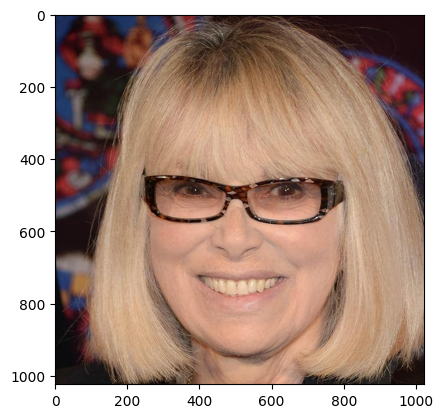

In [123]:
# normalize the image
sampled_im = (sampled_im + 1) / 2

# plot the sampled image
import matplotlib.pyplot as plt
plt.imshow(sampled_im.permute(1, 2, 0))
plt.show()

In [124]:
print(sampled_cond)
sampled_cond = sampled_cond['attribute']

{'attribute': array([0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1])}


In [125]:
# where cond is one print the matching label
labels = ['Male', 'Young', 'Bald', 'Bangs', 'Receding_Hairline', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair', 'Straight_Hair', 'Wavy_Hair', 'No_Beard', 'Goatee', 'Mustache', 'Sideburns', 'Narrow_Eyes', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Eyeglasses']
for i, l in enumerate(labels):
    if sampled_cond[i] == 1:
        print(l)

Bangs
Blond_Hair
Gray_Hair
Straight_Hair
No_Beard
Eyeglasses


In [126]:
# go through the dataset find all image with 1 at position 19 in the condition
indexes_with_eyeglasses = []
for i in range(len(im_dataset)):
    _, cond = im_dataset[i]
    if cond['attribute'][19] == 1:
        indexes_with_eyeglasses.append(i)

In [127]:
indexes_with_eyeglasses

[39,
 75,
 109,
 118,
 143,
 145,
 151,
 280,
 317,
 333,
 355,
 371,
 429,
 520,
 524,
 526,
 533,
 556]

In [171]:
sampled_im, sampled_cond = im_dataset[75]

In [172]:
# add batch dimension
sampled_im = sampled_im.unsqueeze(0).to(device)

In [173]:
# add batch dimension to the condition
sampled_cond = sampled_cond['attribute']

# remove the eyeglasses from the condition
sampled_cond = sampled_cond[:19]

# add batch dimension
sampled_cond = torch.from_numpy(sampled_cond).unsqueeze(0)
print(sampled_cond)


sampled_cond = {'attribute': sampled_cond.to(device)}

tensor([[0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]])


In [174]:
print(sampled_im)

tensor([[[[-0.7569, -0.7569, -0.7569,  ..., -0.7725, -0.7725, -0.7725],
          [-0.7569, -0.7569, -0.7569,  ..., -0.7725, -0.7725, -0.7725],
          [-0.7569, -0.7569, -0.7569,  ..., -0.7725, -0.7725, -0.7725],
          ...,
          [-0.7490, -0.7490, -0.7490,  ..., -0.7804, -0.7725, -0.7569],
          [-0.7490, -0.7490, -0.7490,  ..., -0.8196, -0.8039, -0.7961],
          [-0.7490, -0.7490, -0.7490,  ..., -0.7569, -0.7412, -0.7333]],

         [[-0.6235, -0.6235, -0.6235,  ..., -0.9216, -0.9216, -0.9216],
          [-0.6235, -0.6235, -0.6235,  ..., -0.9216, -0.9216, -0.9216],
          [-0.6235, -0.6235, -0.6235,  ..., -0.9216, -0.9216, -0.9216],
          ...,
          [-0.8275, -0.8275, -0.8275,  ..., -0.8667, -0.8588, -0.8431],
          [-0.8275, -0.8275, -0.8275,  ..., -0.9059, -0.8902, -0.8824],
          [-0.8275, -0.8275, -0.8275,  ..., -0.8431, -0.8275, -0.8196]],

         [[-0.2863, -0.2863, -0.2863,  ..., -0.8902, -0.8902, -0.8902],
          [-0.2863, -0.2863, -

In [8]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")

In [176]:
# ddim inverse sampled_im
with torch.no_grad():
    intermediate_latents = ddim_inversion(scheduler, vae, sampled_im, diffusion_config, sampled_cond, model, train_config, 1000, dir=current_time)

100%|█████████▉| 999/1000 [02:11<00:00,  7.60it/s]


In [178]:
# resample from the last latent
start_latent = intermediate_latents[-1]

with torch.no_grad():
    sample(model, sampled_cond['attribute'], scheduler, train_config, diffusion_model_config, autoencoder_model_config, 
            diffusion_config, dataset_config, vae, use_ddim=True, start_step=0, noise_input=start_latent, dir=current_time, num_steps=1000)

100%|██████████| 1000/1000 [02:11<00:00,  7.61it/s]


In [34]:
import sklearn.linear_model as linear_model
import numpy as np

def find_feature_axis(z, y, method='linear', **kwargs_model):
    """
    function to find axis in the latent space that is predictive of feature vectors

    :param z: vectors in the latent space, shape=(num_samples, num_latent_vector_dimension)
    :param y: feature vectors, shape=(num_samples, num_features)
    :param method: one of ['linear', 'logistic'], or a sklearn.linear_model object, (eg. sklearn.linear_model.ElasticNet)
    :param kwargs_model: parameters specific to a sklearn.linear_model object, (eg., penalty=’l2’)
    :return: feature vectors, shape = (num_latent_vector_dimension, num_features)
    """

    if method == 'linear':
        model = linear_model.LinearRegression(**kwargs_model)
        model.fit(z, y)
    elif method == 'tanh':
        def arctanh_clip(y):
            return np.arctanh(np.clip(y, np.tanh(-3), np.tanh(3)))

        model = linear_model.LinearRegression(**kwargs_model)

        model.fit(z, arctanh_clip(y))
    else:
        raise Exception('method has to be one of ["linear", "tanh"]')

    return model.coef_.transpose()

In [19]:
im_dataset_train = CelebDataset(split='train',
                                im_path=dataset_config['im_path'],
                                im_size=dataset_config['im_size'],
                                im_channels=dataset_config['im_channels'],
                                use_latents=False,
                                latent_path=os.path.join(train_config['task_name'],
                                                         train_config['vqvae_latent_dir_name']),
                                condition_config=temp_conf['condition_config'],
                                )

KeyError: "['Lipstick'] not in index"

In [195]:
# go through the dataset find all image with 1 at position 19 in the condition
indexes_with_eyeglasses = []
indexes_without_eyeglasses = []
for i in tqdm(range(len(im_dataset_train))):
    _, cond = im_dataset_train[i]
    if cond['attribute'][19] == 1:
        indexes_with_eyeglasses.append(i)
    elif len(indexes_without_eyeglasses) < 1000:
        indexes_without_eyeglasses.append(i)

    if len(indexes_with_eyeglasses) == 1000 and len(indexes_without_eyeglasses) == 1000:
        break

print(len(indexes_with_eyeglasses))

 69%|██████▉   | 18705/27000 [02:50<01:15, 109.42it/s]

1000


In [196]:
# save the indexes
import pickle

with open('indexes_with_eyeglasses.pkl', 'wb') as f:
    pickle.dump(indexes_with_eyeglasses, f)

with open('indexes_without_eyeglasses.pkl', 'wb') as f:
    pickle.dump(indexes_without_eyeglasses, f)

In [13]:
# load the indexes
import pickle

with open('indexes_with_eyeglasses.pkl', 'rb') as f:
    indexes_with_eyeglasses = pickle.load(f)

with open('indexes_without_eyeglasses.pkl', 'rb') as f:
    indexes_without_eyeglasses = pickle.load(f)

In [14]:
# create a dataloader just for these indexes
from torch.utils.data import DataLoader
from torch.utils.data import Subset
# take 10 images with eyeglasses and 10 images without eyeglasses
indexes = indexes_with_eyeglasses[0:150] + indexes_without_eyeglasses[0:150]

print(len(indexes))

subset = Subset(im_dataset_train, indexes)
dataloader = DataLoader(subset, batch_size=1, shuffle=False)

300


In [15]:
latens = torch.tensor([])
attribute_desc = torch.tensor([])

current_time = datetime.now().strftime("%Y%m%d-%H%M%S")

# for each image in the training set create a ddim inversion
for i, (im, cond) in tqdm(enumerate(dataloader), total=len(dataloader)):
    # torch clear cache
    torch.cuda.empty_cache()
    im = im.to(device)
    attr = cond['attribute'].clone()    
    
    cond = cond
    cond['attribute'] = cond['attribute'][:, :19].to(device)

    with torch.no_grad():
        intermediate_latents = ddim_inversion(scheduler, vae, im, diffusion_config, cond, model, train_config, 1000, dir=current_time, save_img=False)

    #start_latent = intermediate_latents[-1]

    #start_latent = start_latent.detach().cpu()

    intermediate_latents = intermediate_latents.detach().cpu()

    # stack the results
    latens = torch.cat((latens, intermediate_latents), 0)
    attribute_desc = torch.cat((attribute_desc, attr), 0)

    if i % 20 == 0:
        # save the latents and the attribute description into a file
        torch.save({'latents': latens, 'attribute_desc': attribute_desc}, f'latents_glasses_intermediates_{i}.pt')

        latens = torch.tensor([])
        attribute_desc = torch.tensor([])
    



    

100%|█████████▉| 999/1000 [02:02<00:00,  8.15it/s]/it]


: 

In [82]:
attribute_desc

tensor([[1., 0., 1.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 1.],
        [1., 0., 1.,  ..., 0., 0., 1.],
        ...,
        [0., 1., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.]])

In [83]:
# flatten start_latent to (num_samples, num_latent_vector_dimension)
latens = latens.view(latens.size(0), -1).cpu().numpy()

attribute_desc = attribute_desc.cpu().numpy()


In [84]:
def normalize_feature_axis(feature_slope):
    """
    function to normalize the slope of features axis so that they have the same length

    :param feature_slope: array of feature axis, shape = (num_latent_vector_dimension, num_features)
    :return: same shape of input
    """

    feature_direction = feature_slope / np.linalg.norm(feature_slope, ord=2, axis=0, keepdims=True)
    return feature_direction

In [85]:
feature_slope = find_feature_axis(latens, attribute_desc, method='linear')

""" normalize the feature vectors """
yn_normalize_feature_direction = True
if yn_normalize_feature_direction:
    feature_direction = normalize_feature_axis(feature_slope)
else:
    feature_direction = feature_slope

In [89]:
print(attribute_desc.shape)

(400, 20)


In [91]:
print(feature_direction.shape)

# format back to (1, 3, 64, 64)
feature_direction = feature_direction.reshape(3, 64, 64, 20)

(12288, 20)


In [74]:
print(min(feature_direction[0, 0].flatten()), max(feature_direction[0, 0].flatten()))

-0.046551898 0.0429566


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


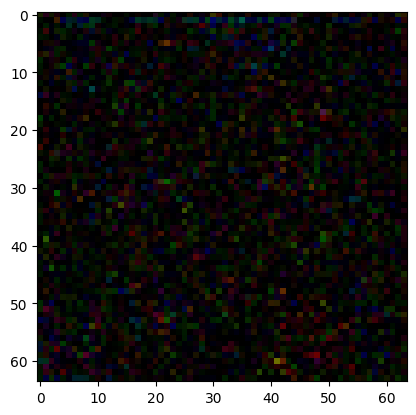

In [75]:
# plot the feature direction
import matplotlib.pyplot as plt

feature_direction = torch.tensor(feature_direction)[0]

plt.imshow(feature_direction.permute(1, 2, 0) * 10)
plt.show()

In [68]:
im_size = dataset_config['im_size'] // 2 ** sum(autoencoder_model_config['down_sample'])

torch.manual_seed(9)

noise_input = torch.randn((train_config['num_samples'],
                        autoencoder_model_config['z_channels'],
                        im_size,
                        im_size)).to(device)

noise_input += feature_direction.to(device) * 10

In [65]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")

In [69]:
#  ['Male', 'Young', 'Bald', 'Bangs', 'Receding_Hairline', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair', 'Straight_Hair', 'Wavy_Hair', 'No_Beard', 'Goatee', 'Mustache', 'Sideburns', 'Narrow_Eyes', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose']
cond = torch.tensor([[1, # Male
                      0, # Young
                      0, # Bald
                      1, # Bangs
                      0, # Receding_Hairline
                      0, # Black_Hair
                      1, # Blond_Hair
                      0, # Brown_Hair
                      0, # Gray_Hair
                      0, # Straight_Hair
                      1, # Wavy_Hair
                      1, # No_Beard
                      0, # Goatee
                      0, # Mustache
                      0, # Sideburns
                      0, # Narrow_Eyes
                      0, # Oval_Face
                      0, # Pale_Skin
                      0  # Pointy_Nose
                      ]]).to(device)

In [70]:
with torch.no_grad():
    for i in range(1):
        ims, cond = sample(model, cond, scheduler, train_config, diffusion_model_config,
                    autoencoder_model_config, diffusion_config, dataset_config, vae, use_ddim=True, dir=current_time, noise_input=noise_input, num_steps=1000)

    

100%|██████████| 1000/1000 [02:13<00:00,  7.47it/s]
